<a href="https://colab.research.google.com/github/jerrymaxxy/data-mining-unet/blob/master/myself_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loader




In [0]:

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

!tar -xf VOCtrainval_11-May-2012.tar



--2020-04-28 15:42:40--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  5.19MB/s    in 6m 16s  

2020-04-28 15:49:03 (5.08 MB/s) - ‘VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [0]:
%tensorflow_version 1.x

In [0]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from datetime import datetime, timedelta
from keras.optimizers import *
# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
X_PATH = "./content/VOCdevkit/VOC2012/JPEGImages/"
Y_PATH = "./content/VOCdevkit/VOC2012/SegmentationClass/"

def get_time():
  d = datetime.today() - timedelta(hours=5)
  return(d.strftime('%Y-%m-%d %H:%M %p'))


In [0]:
name_list_train = open('./train_list/train.txt','r')
lines_train = name_list_train.readlines()
X_train = np.zeros((len(lines_train), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(lines_train), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in range(len(lines_train)):
      file_path = X_PATH + str(lines_train[n][0:-1])+ ".jpg"
      img_x = imread(file_path)[:,:,:IMG_CHANNELS]
      img_x = resize(img_x, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_train[n] = img_x
      file_path = Y_PATH + str(lines_train[n][0:-1])+ ".png"
      img_y = imread(file_path)[:,:,:1]
      img_y = resize(img_y, (IMG_HEIGHT, 1), mode='constant', preserve_range=True)
    
      Y_train[n] = img_y
print(get_time())


Getting and resizing train images and masks ... 
2020-04-28 11:52 AM


In [0]:
name_list_test = open('./train_list/val.txt','r')
lines_test = name_list_test.readlines()
X_test = np.zeros((len(lines_test), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(lines_test), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n in range(len(lines_test)):
      file_path = X_PATH + str(lines_test[n][0:-1])+ ".jpg"
      img_x = imread(file_path)[:,:,:IMG_CHANNELS]
      img_x = resize(img_x, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      X_test[n] = img_x
      file_path = Y_PATH + str(lines_test[n][0:-1])+ ".png"
      img_y = imread(file_path)[:,:,:1]
      img_y = resize(img_y, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      Y_test[n] = img_y
print("done")
print(get_time())


Getting and resizing train images and masks ... 
done
2020-04-28 10:53 AM


# UNET Model

In [0]:
from keras import optimizers
# Build U-Net model
def unet(learning_rate,optimizer):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / (IMG_HEIGHT-1)) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  optimizerss = optimizer(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizerss, metrics=['accuracy'])
  return model



print(get_time())


2020-04-28 10:53 AM


In [0]:
def fit_model(epochs, batch_size):
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, 
                callbacks=[earlystopper, checkpointer])
  return(results)
  

In [0]:
epochs = 10
def fit_model(epochs, batch_size):
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, 
                callbacks=[earlystopper, checkpointer])
  return(results)
start = datetime.now()
  
model = unet(1e-3,Adam)
results = fit_model(epochs,50)



end = datetime.now()
time = end-start


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 387 samples, validate on 44 samples
Epoch 1/10
387/387 [==============================] - 72s 185ms/step - loss: 0.7548 - accuracy: 0.6218 - val_loss: 0.5774 - val_accuracy: 0.7301

Epoch 00001: val_loss improved from inf to 0.57737, saving model to model-dsbowl2018-1.h5
Epoch 2/10
387/387 [==============================] - 70s 181ms/step - loss: 0.6193 - accuracy: 0.6784 - val_loss: 0.5787 - val_accuracy: 0.7342

Epoch 00002: val_loss did not improve from 0.57737
Epoch 3/10
387/387 [==============================] - 69s 179ms/step - loss: 0.5715 - accuracy: 0.7074 - val_loss: 0.5350 - val_accuracy: 0.7265

Epoch 00003: val_loss improved from 0.57737 to 0.53503, saving model to model-dsbowl2018-1.h5
Epoch 4/10
387/387 [==============================] - 70s 180ms/step - loss: 0.5690 - accuracy: 0.7126 - 

In [0]:
def get_performance():
  print("Time: " + str(time))
  print("number of parameters: " + str(model.count_params()))
  print("Accuracy: " + str(results.history['accuracy'][-1]))
  plt.plot(np.arange(len(results.epoch)),results.history['accuracy'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')



Time: 0:09:23.836483
number of parameters: 1941105
Accuracy: 0.7383767


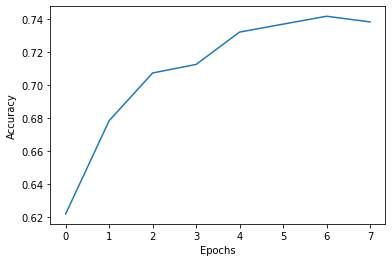

In [0]:
get_performance()

# Model Fitting

Fit the model on learning rate from 1e-3 to 1e-5, and optimizers:  
Store their running time, number of parameters and accuracy in dataframe df
Store the accuracy of each epoch in accuracy_df

In [0]:
epochs = 10
lr_list = [1e-3, 1e-4, 1e-5]
optimizer_list = ['SGD','Adam','Adamax']
df = pd.DataFrame(np.zeros((3, 9)))
accuracy_df = pd.DataFrame(np.zeros((epochs, 9)))
df.index = ['Time','Num of Paras','Accuracy']
colname_list = [str(i) + " lr = " + str(j) for i in optimizer_list for j in lr_list]
df.columns= colname_list
accuracy_df.columns= colname_list
i = 0

for opt in optimizer_list: 
  for lr in lr_list:
      print(str(opt) + " lr=" +str(lr))

      model = unet(lr,eval(opt))
      start = datetime.now()
      
      results = fit_model(epochs,50)
      end = datetime.now()
      time = end-start
      df.iloc[0,i] = time
      df.iloc[1,i] = model.count_params()
      df.iloc[2,i] = results.history['accuracy'][-1]
      results.history['accuracy']
      accuracy_df.iloc[:,i] = results.history['accuracy']

      i += 1

print(get_time())


SGD lr=0.001
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 387 samples, validate on 44 samples
Epoch 1/10
387/387 [==============================] - 72s 186ms/step - loss: 0.7909 - accuracy: 0.5443 - val_loss: 0.7538 - val_accuracy: 0.5118

Epoch 00001: val_loss improved from inf to 0.75381, saving model to model-dsbowl2018-1.h5
Epoch 2/10
387/387 [==============================] - 70s 180ms/step - loss: 0.7668 - accuracy: 0.5704 - val_loss: 0.7271 - val_accuracy: 0.5537

Epoch 00002: val_loss improved from 0.75381 to 0.72712, saving model to model-dsbowl2018-1.h5
Epoch 3/10
387/387 [==============================] - 70s 180ms/step - loss: 0.7547 - accuracy: 0.5832 - val_loss: 0.7113 - val_accuracy: 0.5802

Epoch 00003: val_loss improved from 0.72712 to 0.71134, saving model to model-dsbowl2018-1.h5
Epoch 4/10
387/387 [=============================

KeyboardInterrupt: ignored

In [0]:
df

,SGD lr = 0.001,SGD lr = 0.0001,SGD lr = 1e-05,Adam lr = 0.001,Adam lr = 0.0001,Adam lr = 1e-05,Adamax lr = 0.001,Adamax lr = 0.0001,Adamax lr = 1e-05
Time,0:11:46.317607,0:11:43.385677,0:11:43.223159,0:11:48.447457,0.0,0.0,0.0,0.0,0.0
Num of Paras,1941105,1941105,1941105,1941105,0.0,0.0,0.0,0.0,0.0
Accuracy,0.607996,0.496327,0.42322,0.780242,0.0,0.0,0.0,0.0,0.0


In [0]:
accuracy_df

,SGD lr = 0.001,SGD lr = 0.0001,SGD lr = 1e-05,Adam lr = 0.001,Adam lr = 0.0001,Adam lr = 1e-05,Adamax lr = 0.001,Adamax lr = 0.0001,Adamax lr = 1e-05
0,0.544291,0.461048,0.405909,0.643932,0.0,0.0,0.0,0.0,0.0
1,0.570355,0.465257,0.407611,0.683800,0.0,0.0,0.0,0.0,0.0
2,0.583205,0.469475,0.409546,0.719560,0.0,0.0,0.0,0.0,0.0
3,0.590287,0.473587,0.411897,0.718434,0.0,0.0,0.0,0.0,0.0
4,0.595621,0.477368,0.413614,0.721229,0.0,0.0,0.0,0.0,0.0
5,0.602091,0.481172,0.415355,0.747712,0.0,0.0,0.0,0.0,0.0
6,0.605200,0.485197,0.417634,0.747138,0.0,0.0,0.0,0.0,0.0
7,0.605521,0.489168,0.419411,0.759759,0.0,0.0,0.0,0.0,0.0
8,0.609886,0.492855,0.421537,0.775379,0.0,0.0,0.0,0.0,0.0
9,0.607996,0.496327,0.423220,0.780242,0.0,0.0,0.0,0.0,0.0


Change the struture of model

# UNET v1


Now, we only do one convolution on each layer of the model

In [0]:
# Build U-Net model
def unet(learning_rate,optimizer):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / (IMG_HEIGHT-1)) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  #c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  #c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  #c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  #c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  #c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  #c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  #c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  #c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  #c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  optimizer = optimizer(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model


print(get_time())
unet(0.001,SGD).summary()

2020-04-28 11:08 AM
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 128, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         lambda_2[0][0]                   
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 128, 128, 16) 0           conv2d_20[0][0]                  
________________________________________________________________________

In [0]:
epochs = 10
def fit_model(epochs, batch_size):
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, 
                callbacks=[earlystopper, checkpointer])
  return(results)
start = datetime.now()
  
model = unet(1e-3,Adam)
results = fit_model(epochs,50)



end = datetime.now()
time = end-start


Train on 387 samples, validate on 44 samples
Epoch 1/10
387/387 [==============================] - 43s 111ms/step - loss: 0.7210 - accuracy: 0.6169 - val_loss: 0.5970 - val_accuracy: 0.7302

Epoch 00001: val_loss improved from inf to 0.59704, saving model to model-dsbowl2018-1.h5
Epoch 2/10
387/387 [==============================] - 42s 108ms/step - loss: 0.6434 - accuracy: 0.6693 - val_loss: 0.6008 - val_accuracy: 0.7301

Epoch 00002: val_loss did not improve from 0.59704
Epoch 3/10
387/387 [==============================] - 42s 108ms/step - loss: 0.6303 - accuracy: 0.6704 - val_loss: 0.5592 - val_accuracy: 0.7373

Epoch 00003: val_loss improved from 0.59704 to 0.55924, saving model to model-dsbowl2018-1.h5
Epoch 4/10
387/387 [==============================] - 42s 109ms/step - loss: 0.5865 - accuracy: 0.7082 - val_loss: 1.7674 - val_accuracy: 0.3111

Epoch 00004: val_loss did not improve from 0.55924
Epoch 5/10
387/387 [==============================] - 42s 109ms/step - loss: 0.6374 -

Time: 0:07:06.125186
number of parameters: 958865
Accuracy: 0.74793535


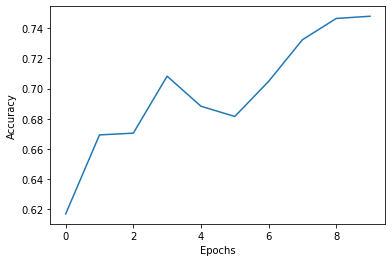

In [0]:
get_performance()

# UNET V2


We use only on convolution at each layer, and add another layer at the bottom of the model, and use two times deconvolotion to recover the image size.


In [0]:
from keras import optimizers
# Build U-Net model
def unet(learning_rate,optimizer):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / (IMG_HEIGHT-1)) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s) #128 128 16
  c1 = Dropout(0.1) (c1)
  #c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1) # 64 64 32

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  #c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2) # 32 32 64

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
 # c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3) # 16 16 128

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  #c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4) # 8 8 256

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  #c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5) # 8 8 256
  p_extra = MaxPooling2D(pool_size=(2, 2)) (c5) # 4 4 512

  c_extra = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p_extra)
  c_extra = Dropout(0.3) (c_extra)
  #c_extra = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c_extra) # 4 4 256
  
  
  u_extra = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c_extra) # 8 8 256
  
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (u_extra) # 16 16 256
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
 # c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
 # c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  #c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
 # u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  optimizerss = optimizer(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizerss, metrics=['accuracy'])
  return model



print(get_time())


2020-04-28 11:16 AM


In [0]:
epochs = 10
def fit_model(epochs, batch_size):
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, 
                callbacks=[earlystopper, checkpointer])
  return(results)
start = datetime.now()
  
model = unet(1e-3,Adam)
results = fit_model(epochs,50)



end = datetime.now()
time = end-start


Train on 387 samples, validate on 44 samples
Epoch 1/10
387/387 [==============================] - 45s 115ms/step - loss: 0.6907 - accuracy: 0.6262 - val_loss: 0.5840 - val_accuracy: 0.7322

Epoch 00001: val_loss improved from inf to 0.58398, saving model to model-dsbowl2018-1.h5
Epoch 2/10
387/387 [==============================] - 43s 112ms/step - loss: 0.6011 - accuracy: 0.6935 - val_loss: 0.5774 - val_accuracy: 0.7020

Epoch 00002: val_loss improved from 0.58398 to 0.57744, saving model to model-dsbowl2018-1.h5
Epoch 3/10
387/387 [==============================] - 43s 112ms/step - loss: 0.5364 - accuracy: 0.7410 - val_loss: 0.6902 - val_accuracy: 0.5856

Epoch 00003: val_loss did not improve from 0.57744
Epoch 4/10
387/387 [==============================] - 43s 112ms/step - loss: 0.5329 - accuracy: 0.7426 - val_loss: 0.5835 - val_accuracy: 0.6762

Epoch 00004: val_loss did not improve from 0.57744
Epoch 5/10
387/387 [==============================] - 43s 112ms/step - loss: 0.5243 -

Time: 0:05:11.643664
number of parameters: 1614625
Accuracy: 0.7598784


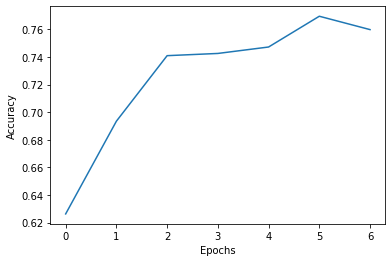

In [0]:
get_performance()

# UNET V3


We use one convolution only at the input image tile and output segmentation layer

In [0]:
from keras import optimizers
# Build U-Net model
def unet(learning_rate,optimizer):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / (IMG_HEIGHT-1)) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  #c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  #c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  optimizerss = optimizer(lr=learning_rate)
  model.compile(loss='binary_crossentropy', optimizer=optimizerss, metrics=['accuracy'])
  return model



print(get_time())


2020-04-28 11:21 AM


In [0]:
epochs = 10
def fit_model(epochs, batch_size):
  earlystopper = EarlyStopping(patience=5, verbose=1)
  checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
  results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=batch_size, epochs=epochs, 
                callbacks=[earlystopper, checkpointer])
  return(results)
start = datetime.now()
  
model = unet(1e-3,Adam)
results = fit_model(epochs,50)



end = datetime.now()
time = end-start


Train on 387 samples, validate on 44 samples
Epoch 1/10
387/387 [==============================] - 60s 155ms/step - loss: 0.6924 - accuracy: 0.6270 - val_loss: 0.6049 - val_accuracy: 0.7209

Epoch 00001: val_loss improved from inf to 0.60492, saving model to model-dsbowl2018-1.h5
Epoch 2/10
387/387 [==============================] - 58s 151ms/step - loss: 0.6224 - accuracy: 0.6768 - val_loss: 0.7461 - val_accuracy: 0.4361

Epoch 00002: val_loss did not improve from 0.60492
Epoch 3/10
387/387 [==============================] - 58s 151ms/step - loss: 0.6156 - accuracy: 0.6702 - val_loss: 0.5592 - val_accuracy: 0.7483

Epoch 00003: val_loss improved from 0.60492 to 0.55921, saving model to model-dsbowl2018-1.h5
Epoch 4/10
387/387 [==============================] - 58s 151ms/step - loss: 0.5974 - accuracy: 0.6933 - val_loss: 0.5274 - val_accuracy: 0.7567

Epoch 00004: val_loss improved from 0.55921 to 0.52736, saving model to model-dsbowl2018-1.h5
Epoch 5/10
387/387 [======================

Time: 0:08:57.167418
number of parameters: 1936465
Accuracy: 0.7484079


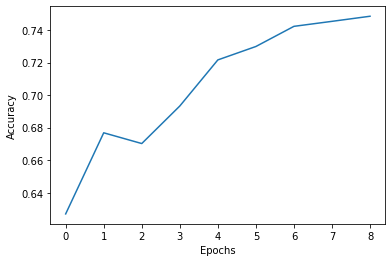

In [0]:
get_performance()